In [1]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import re
import seaborn as sns
import torch
import os
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TOKENIZERS_PARALLELISM"] = "false"  
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "general_stance_model_gemma9_balanced_db_k", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth: Fast Gemma2 patching release 2024.7
   \\   /|    GPU: NVIDIA A100-PCIE-40GB. Max memory: 39.394 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.7 patched 42 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [3]:
def generate_prediction(instruction, input_text):
    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
    
    ### Instruction:
    {}
    
    ### Input:
    {}
    
    ### Response:
    {}"""

    inputs = tokenizer(
        [alpaca_prompt.format(instruction, input_text, "")], return_tensors="pt"
    ).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
    
    prediction = tokenizer.batch_decode(outputs)
    
    # Extract the text after "### Response:"
    response_text = prediction[0].split("### Response:")[-1].strip()
    
    try:
        # Use regex to extract the first word
        stance_word = re.match(r'\w+', response_text).group(0)
    except Exception as e:
        # Print out debug info
        print(f"Error occurred during stance word extraction: {e}")
        print(f"Full response text: {response_text}")
        print(f"Prediction: {prediction}")
        stance_word = None
    
    return stance_word

In [4]:
eval_dataset = load_dataset("Supakrit65/llama3-clean-general-stance", split = "test")
eval_dataset = pd.DataFrame(eval_dataset)
eval_dataset['topic'] = eval_dataset['input'].apply(lambda x: re.search(r'on topic of `([^`]+)`', x).group(1))
eval_dataset.topic.value_counts()

topic
stay at home orders    560
face masks             473
school closures        454
Name: count, dtype: int64

In [5]:
predictions = []
actuals = []

model.generation_config.pad_token_id = tokenizer.pad_token_id

for idx, example in tqdm(eval_dataset.iterrows(), desc="Processing examples", unit="example", total=len(eval_dataset)):
    instruction = example["instruction"]
    input_text = example["input"]
    actual_output = example["output"]

    predicted_output = generate_prediction(instruction, input_text)

    predictions.append(predicted_output)
    actuals.append(actual_output)

    eval_dataset.at[idx, 'prediction'] = predicted_output

Processing examples: 100%|██████████| 1487/1487 [06:29<00:00,  3.82example/s]


In [6]:
from collections import Counter

def unique(list1):
    # Initialize a null list
    unique_list = []

    # Traverse for all elements
    for x in list1:
        # Check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            unique_list.append(type(x))
    
    # Print unique list and types
    for x in unique_list:
        print(x)
    
    # Count occurrences of each label
    value_counts = Counter(list1)
    
    # Print value counts
    print("\nValue counts for class labels:")
    for label, count in value_counts.items():
        print(f"{label}: {count}")


In [7]:

# Example usage with predictions
print('**Predicts**')
unique(predictions)
print('-' * 50)
print('**Actuals**')
unique(actuals)

**Predicts**
Neutral
<class 'str'>
Favorable
<class 'str'>
Against
<class 'str'>

Value counts for class labels:
Neutral: 815
Favorable: 499
Against: 173
--------------------------------------------------
**Actuals**
Neutral
<class 'str'>
Favorable
<class 'str'>
Against
<class 'str'>

Value counts for class labels:
Neutral: 813
Favorable: 487
Against: 187


In [8]:
def preprocess_predictions(predictions):
    processed_predictions = []
    for prediction in predictions:
        prediction_lower = prediction.lower()
        if 'favor' in prediction_lower or 'favour' in prediction_lower:
            processed_predictions.append('Favorable')
        elif 'against' in prediction_lower:
            processed_predictions.append('Against')
        elif 'neutral' in prediction_lower:
            processed_predictions.append('Neutral')
        else:
            print(prediction)
            raise ValueError('Model Dumb')
    return processed_predictions

predictions = preprocess_predictions(predictions)

In [9]:
eval_dataset['predictions'] = predictions
eval_dataset['actuals'] = actuals

In [10]:
eval_dataset.to_csv('smm4h_task2_gemma_trial.csv', index=False)

In [31]:
import plotly.express as px
import pandas as pd

eval_dataset = pd.read_csv('smm4h_task2_gemma.csv')
stance_counts = eval_dataset.groupby(['topic', 'predictions']).size().unstack(fill_value=0).reset_index()

# Melt the DataFrame for easier plotting with Plotly
stance_counts_melted = stance_counts.melt(id_vars='topic', var_name='Stance', value_name='Count')

# Plotting
fig = px.bar(stance_counts_melted, x='topic', y='Count', color='Stance', text='Count',
             title='Fine-tuned Gemma 2 Prediction Results by Topic and Stance',
             labels={'topic': 'Topic', 'Count': 'Count', 'Stance': 'Stance'})

# Update layout for better readability and set y-axis maximum value to 400
fig.update_layout(barmode='group', xaxis_title='Topic', yaxis_title='Count', legend_title='Stance', yaxis=dict(range=[0, 400]))

# Update traces to show count annotations
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Show the plot
fig.show()

In [11]:
def compute_metrics(predictions, actuals):
    pred_labels = predictions  # Assuming predictions are already label-like
    true_labels = actuals

    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

Overall Classification Report:
              precision    recall  f1-score   support

     Against       0.65      0.59      0.62       187
   Favorable       0.76      0.77      0.77       487
     Neutral       0.80      0.81      0.81       813

    accuracy                           0.77      1487
   macro avg       0.74      0.73      0.73      1487
weighted avg       0.77      0.77      0.77      1487



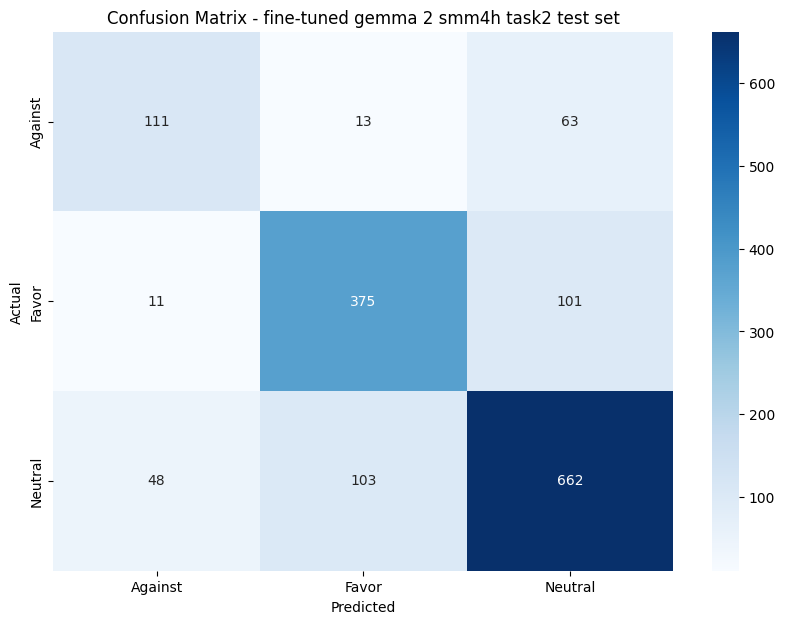

F1 score for all topic : 0.77101628062829
F1 score for topic 'school closures': 0.7374419415768079
F1 score for topic 'stay at home orders': 0.7727071519562395
F1 score for topic 'face masks': 0.7975213565939665

Classification Report for topic 'school closures':
              precision    recall  f1-score   support

     Against       0.14      0.09      0.11        23
   Favorable       0.77      0.74      0.76       205
     Neutral       0.76      0.82      0.79       226

    accuracy                           0.74       454
   macro avg       0.56      0.55      0.55       454
weighted avg       0.73      0.74      0.74       454


Classification Report for topic 'stay at home orders':
              precision    recall  f1-score   support

     Against       0.71      0.71      0.71       116
   Favorable       0.62      0.68      0.65        92
     Neutral       0.83      0.82      0.82       352

    accuracy                           0.77       560
   macro avg       0.72    

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Calculate overall metrics
overall_metrics = classification_report(eval_dataset["actuals"], eval_dataset["predictions"])
print("Overall Classification Report:")
print(overall_metrics)

# Compute confusion matrix
conf_matrix = confusion_matrix(eval_dataset["actuals"], eval_dataset["predictions"])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Against', 'Favor', 'Neutral'], yticklabels=['Against', 'Favor', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - fine-tuned gemma 2 smm4h task2 test set')
plt.show()

f1 = f1_score(eval_dataset["actuals"], eval_dataset["predictions"], average='weighted')
print(f"F1 score for all topic : {f1}")

# Calculate F1 score for each topic
topics = eval_dataset["topic"].unique()
for topic in topics:
    topic_data = eval_dataset[eval_dataset["topic"] == topic]
    f1 = f1_score(topic_data["actuals"], topic_data["predictions"], average='weighted')
    print(f"F1 score for topic '{topic}': {f1}")


# Optionally, you can also compute and print the classification report for each topic
for topic in topics:
    topic_data = eval_dataset[eval_dataset["topic"] == topic]
    topic_report = classification_report(topic_data["actuals"], topic_data["predictions"])
    print(f"\nClassification Report for topic '{topic}':")
    print(topic_report)
